# LSTM Stock Predictor Using Fear and Greed Index

In [1]:
import numpy as np
import pandas as pd


In [2]:
# Set the random seed for reproducibility:
from numpy.random import seed
seed(1)

from tensorflow import random
random.set_seed(2)

In [3]:
# Load the fear and greed sentiment data for Bitcoin:
btc_sentiment_df = pd.read_csv('btc_sentiment.csv',index_col="date",infer_datetime_format=True,parse_dates=True)
btc_sentiment_df = btc_sentiment_df.drop(columns="fng_classification")
btc_sentiment_df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [4]:
# Load the historical closing prices for Bitcoin:
btc_historic_df = pd.read_csv('btc_historic.csv',index_col="Date",infer_datetime_format=True,parse_dates=True)['Close']
btc_historic_df = btc_historic_df.sort_index()
btc_historic_df.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [5]:
# Join the data into a single DataFrame:
btc_df = btc_sentiment_df.join(btc_historic_df, how="inner")
btc_df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [6]:
btc_df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


## Data Preparation
Prepare the training and testing data for the model; the model will use a rolling 10 day window to predict the 11th day closing price.

In [7]:
# This function accepts the column number for the features (X) and the target (y):
def window_data(btc_df,window,feature_col_number,target_col_number):
    X = []
    y = []
    for i in range(len(btc_df) - window -1):
        features = btc_df.iloc[i: (i + window),feature_col_number]
        target = btc_df.iloc[(i + window),target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1,1)

In [8]:
## Predict Closing Prices using a 10 day window of previous fng values:
window_size = 10

feature_column = 0
target_column = 1

X, y = window_data(btc_df, window_size, feature_column, target_column)

In [9]:
# Use 70% of the data for training and the remainder for testing:
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [10]:
# Use the MinMaxScaler to scale data between 0 and 1:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [11]:
# Reshape the features for the model:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

---

## Build and Train the LSTM RNN

1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [13]:
# Build the LSTM model:
lstm_model = Sequential()

units = 30
dropout_fraction = 0.2

# Layer 1:
lstm_model.add(LSTM(units=units,return_sequences=True,input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(dropout_fraction))

# Layer 2:
lstm_model.add(LSTM(units=units,return_sequences=True))
lstm_model.add(Dropout(dropout_fraction))

# Layer 3:
lstm_model.add(LSTM(units=units))
lstm_model.add(Dropout(dropout_fraction))

# Output layer:
lstm_model.add(Dense(1))

In [14]:
# Compile the model:
lstm_model.compile(optimizer="adam",loss="mean_squared_error")

In [15]:
# Summarize the model:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [16]:
# Train the model using at least 10 epochs, don't shuffle the data, and experiement with the batch size (a smaller batch size is recommended):
lstm_model.fit(X_train,y_train,epochs=10,shuffle=False,batch_size=1)

Epoch 1/10
372/372 [==============================] - 7s 7ms/step - loss: 0.0667
Epoch 2/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0717
Epoch 3/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0743
Epoch 4/10
372/372 [==============================] - 7s 19ms/step - loss: 0.0777
Epoch 5/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0724
Epoch 6/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0735
Epoch 7/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0708
Epoch 8/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0682
Epoch 9/10
372/372 [==============================] - 4s 10ms/step - loss: 0.0642
Epoch 10/10
372/372 [==============================] - 6s 16ms/step - loss: 0.0712


---

## Model Performance

1. Evaluate the model using `X_test` and `y_test` data.
2. Use the X_test data to make predictions.
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart.

In [17]:
# Evaluate the model:
lstm_model.evaluate(X_test,y_test)

5/5 [==============================] - 1s 4ms/step - loss: 0.1219


0.12194047123193741

In [18]:
# Make predictions:
predictions = lstm_model.predict(X_test)

In [19]:
# Recover the original prices instead of the scaled version:
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

In [20]:
# Create a DataFrame of Real and Predicted values:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = btc_df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,4717.979980
2019-02-21,3974.050049,4793.755371
2019-02-22,3937.040039,4861.982910
2019-02-23,3983.530029,4912.349121
2019-02-24,4149.089844,4949.642578


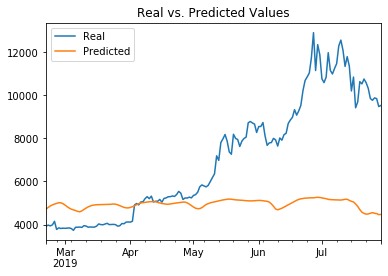

In [21]:
# Plot Real vs. Predicted values as a line chart:
stocks.plot(title='Real vs. Predicted Values')